In [1]:
!nvidia-smi

Sat Mar 30 09:03:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              25W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.7.0 True


# Install Pre-Built Detectron2

In [3]:
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html
     |████████████████████████████████| 6.4 MB 21.2 MB/s 
     |████████████████████████████████| 130 kB 28.5 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 403 kB 45.2 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 
     |████████████████████████████████| 154 kB 77.1 MB/s 
     |████████████████████████████████| 117 kB 65.9 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61431 sha256=bf0db8f47f7c24fed52b0137ba81ad66dbd6ff80f6d641c4754982612a438a2e
  Stored in directory: /root/.cache/pip/wheels/af/cd/23/3fb62ec8606cb08cc18abb8d67bec255baf353623be889da1e
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144573 sha256=1ed00ba40cd95c3753eeea8644917a1687e6d72fd689af10b7d73bacd2da5d60
  Stored in directory: /root/.cache/pip/wheels/8b/8d

In [4]:
!python -m detectron2.utils.collect_env

----------------------  -------------------------------------------------------------------------------
sys.platform            linux
Python                  3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) [GCC 9.3.0]
numpy                   1.19.5
detectron2              0.5 @/opt/conda/lib/python3.7/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.0
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.7.0 @/opt/conda/lib/python3.7/site-packages/torch
PyTorch debug build     True
GPU available           Yes
GPU 0                   Tesla P100-PCIE-16GB (arch=6.0)
CUDA_HOME               /usr/local/cuda
Pillow                  7.2.0
torchvision             0.8.1 @/opt/conda/lib/python3.7/site-packages/torchvision
torchvision arch flags  3.5, 5.0, 6.0, 7.0, 7.5, 8.0
fvcore                  0.1.5.post20221221
iopath                  0.1.8
cv2                   

In [5]:
# detectron2 imports
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LVISEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import ColorMode


# other libs (you can remove unnecessary imports)

import torch, torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image
import cv2
import numpy as np
import IPython
import json
import os
import json
import csv
import time
#import random
from pathlib import Path

# Register Dataset

In [6]:
def create_data_pairs(input_path, detectron_img_path, detectron_annot_path, dir_type = 'train'):

    img_paths = Path(input_path + dir_type + '/images/').glob('*.jpg')

    pairs = []
    for img_path in img_paths:

        file_name_tmp = str(img_path).split('/')[-1].split('.')
        file_name_tmp.pop(-1)
        file_name = '.'.join((file_name_tmp))

        label_path = Path(input_path + dir_type + '/labels/' + file_name + '.txt')

        if label_path.is_file():

            line_img = detectron_img_path + dir_type+'/images/'+ file_name + '.jpg'
            line_annot = detectron_annot_path+dir_type+'/labels/' + file_name + '.txt'
            pairs.append([line_img, line_annot])

    return pairs

In [7]:
input_path = '/kaggle/input/blood-cell-detection-datatset/'
detectron_img_path = '/kaggle/input/blood-cell-detection-datatset/'
detectron_annot_path = '/kaggle/input/blood-cell-detection-datatset/'

In [8]:
train = create_data_pairs(input_path, detectron_img_path, detectron_annot_path, 'train')
val = create_data_pairs(input_path, detectron_img_path, detectron_annot_path, 'valid')
test = create_data_pairs(input_path, detectron_img_path, detectron_annot_path, 'test')

In [9]:
def create_coco_format(data_pairs):

    data_list = []

    for i, path in enumerate(data_pairs):

        filename = path[0]

        img_h, img_w = cv2.imread(filename).shape[:2]

        img_item = {}
        img_item['file_name'] = filename
        img_item['image_id'] = i
        img_item['height']= img_h
        img_item['width']= img_w

        print(str(i), filename)


        annotations = []
        with open(path[1]) as annot_file:
            lines = annot_file.readlines()
            for line in lines:
                if line[-1]=="\n":
                  box = line[:-1].split(' ')
                else:
                  box = line.split(' ')

                class_id = box[0]
                x_c = float(box[1])
                y_c = float(box[2])
                width = float(box[3])
                height = float(box[4])

                x1 = (x_c - (width/2)) * img_w
                y1 = (y_c - (height/2)) * img_h
                x2 = (x_c + (width/2)) * img_w
                y2 = (y_c + (height/2)) * img_h

                annotation = {
                    "bbox": list(map(float,[x1, y1, x2, y2])),
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": int(class_id),
                    "iscrowd": 0
                }
                annotations.append(annotation)
            img_item["annotations"] = annotations
        data_list.append(img_item)
    return data_list

In [10]:
train_list = create_coco_format(train)
val_list = create_coco_format(val)
test_list = create_coco_format(test)

0 /kaggle/input/blood-cell-detection-datatset/train/images/BloodImage_00030_jpg.rf.4e4d7bc73ac7238c3d14ae6e2c8cd870.jpg
1 /kaggle/input/blood-cell-detection-datatset/train/images/BloodImage_00074_jpg.rf.63db3a56b71e1c75bb9ff8c01559a68f.jpg
2 /kaggle/input/blood-cell-detection-datatset/train/images/BloodImage_00242_jpg.rf.02983cfb9790005f554e550d85ad7ac9.jpg
3 /kaggle/input/blood-cell-detection-datatset/train/images/BloodImage_00163_jpg.rf.a2293ab690bd26238ed8e89acc19a722.jpg
4 /kaggle/input/blood-cell-detection-datatset/train/images/BloodImage_00367_jpg.rf.f1359dd8a22323b1639da40647041ca6.jpg
5 /kaggle/input/blood-cell-detection-datatset/train/images/BloodImage_00148_jpg.rf.61a965283c8eeb39bd195a0910c737cc.jpg
6 /kaggle/input/blood-cell-detection-datatset/train/images/BloodImage_00310_jpg.rf.5eb5575e00f460c24bf86cae40bb6821.jpg
7 /kaggle/input/blood-cell-detection-datatset/train/images/BloodImage_00164_jpg.rf.c54772d27774dac5a2e3b705568fda5c.jpg
8 /kaggle/input/blood-cell-detection-dat

In [11]:
for catalog_name, file_annots in [("train", train_list), ("val", val_list)]:
    DatasetCatalog.register(catalog_name, lambda file_annots=file_annots: file_annots)
    MetadataCatalog.get(catalog_name).set(thing_classes=['Platelets', 'RBC', 'WBC']) #Corresponding data


In [12]:
dataset = DatasetCatalog.get("train")
metadata = MetadataCatalog.get("train")

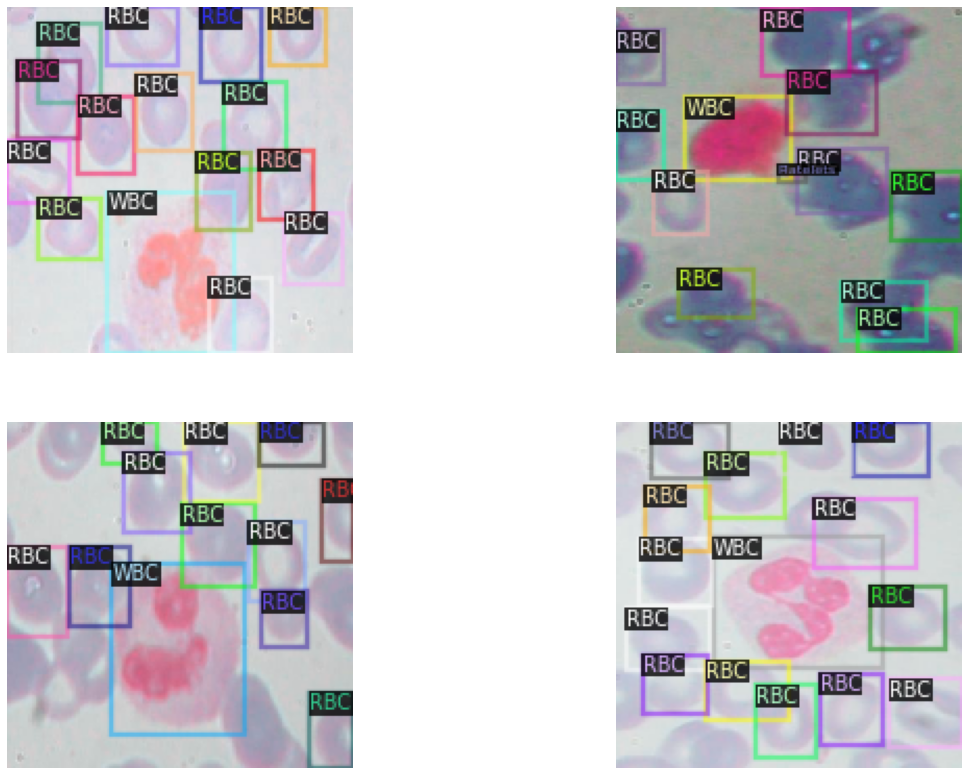

In [13]:
import random
fig, ax = plt.subplots(2, 2, figsize =(20,14))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
for d in random.sample(dataset, 4):
    i=i+1    
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1],
                   metadata=metadata, 
                   scale=0.4, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    indices[i].grid(False)
    indices[i].axis('off')
    indices[i].imshow(out.get_image()[:, :, ::-1])

In [14]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T

def custom_mapper(dataset):
    
    dataset = copy.deepcopy(dataset)
    image = utils.read_image(dataset["file_name"], format="BGR")
    transform_list = [T.Resize((640,640)),
                      T.RandomBrightness(0.9, 1.1),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                      T.RandomCrop("absolute", (640, 640))
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset["instances"] = utils.filter_empty_instances(instances)
    return dataset
class AugTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [15]:
cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml" 
#config_name = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))

cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 3500 #adjust up if val mAP is still rising, adjust down if overfit
#cfg.SOLVER.STEPS = (100, 500) # must be less than  MAX_ITER 
#cfg.SOLVER.GAMMA = 0.05


cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


#Training using custom trainer defined above
#trainer = AugTrainer(cfg) 
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/30 09:04:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 223MB/s]                           


[03/30 09:04:50 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[03/30 09:05:03 d2.utils.events]:  eta: 0:33:30  iter: 19  total_loss: 3.123  loss_cls: 1.884  loss_box_reg: 0.8634  loss_rpn_cls: 0.3109  loss_rpn_loc: 0.06516  time: 0.5594  data_time: 0.0173  lr: 4.9953e-06  max_mem: 2923M
[03/30 09:05:14 d2.utils.events]:  eta: 0:33:22  iter: 39  total_loss: 2.912  loss_cls: 1.773  loss_box_reg: 0.8631  loss_rpn_cls: 0.2301  loss_rpn_loc: 0.07134  time: 0.5659  data_time: 0.0106  lr: 9.9903e-06  max_mem: 2923M
[03/30 09:05:26 d2.utils.events]:  eta: 0:33:11  iter: 59  total_loss: 2.551  loss_cls: 1.538  loss_box_reg: 0.8802  loss_rpn_cls: 0.1072  loss_rpn_loc: 0.05997  time: 0.5634  data_time: 0.0120  lr: 1.4985e-05  max_mem: 2923M
[03/30 09:05:37 d2.utils.events]:  eta: 0:32:59  iter: 79  total_loss: 2.364  loss_cls: 1.292  loss_box_reg: 0.8738  loss_rpn_cls: 0.1469  loss_rpn_loc: 0.07779  time: 0.5621  data_time: 0.0114  lr: 1.998e-05  max_mem: 2923M
[03/30 09:05:48 d2.utils.events]:  eta: 0:32:48  iter: 99  total_loss: 2.108  loss_cls: 1.032  lo

# evaluator

In [16]:
evaluator = COCOEvaluator("val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "val")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [03/30 09:37:16 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/30 09:37:16 d2.evaluation.coco_evaluation]: 'val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[03/30 09:37:16 d2.data.datasets.coco]: Converting annotations of dataset 'val' to COCO format ...)
[03/30 09:37:16 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/30 09:37:16 d2.data.datasets.coco]: Conversion finished, #images: 73, #annotations: 967
[03/30 09:37:16 d2.data.datasets.coco]: Caching COCO format annotations at './output/val_coco_format.json' ...
[03/30 09:37:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/30 09:37:16 d2.data.common]: Serializing 73 elements to byte tensors and concatenating them all ...
[03/30 09:

OrderedDict([('bbox',
              {'AP': 61.413858068580595,
               'AP50': 92.43624898813903,
               'AP75': 68.77094196354038,
               'APs': 47.40988377639843,
               'APm': 63.32914407777478,
               'APl': 49.81633276482241,
               'AP-Platelets': 47.26641316004852,
               'AP-RBC': 60.8617351502602,
               'AP-WBC': 76.11342589543305})])

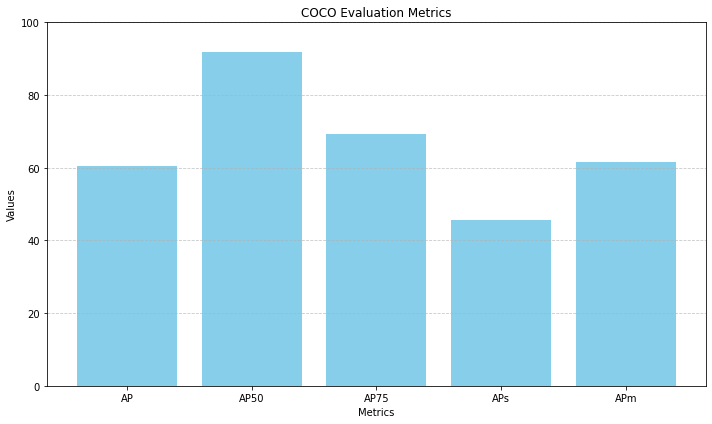

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

# Define the metrics and their corresponding values
metrics = ['AP', 'AP50', 'AP75', 'APs', 'APm']
values = [60.533, 91.903, 69.383, 45.678, 61.620]

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('COCO Evaluation Metrics')
plt.ylim(0, 100)  # Set y-axis limit to 0-100 for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()
plt.savefig('AP_COCO.png')


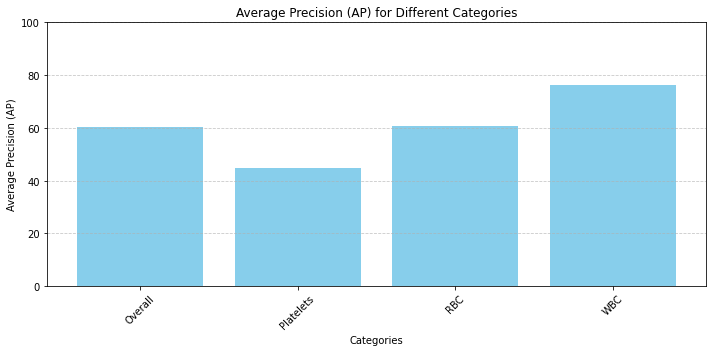

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt

# Define the categories and their corresponding AP values
categories = ['Overall', 'Platelets', 'RBC', 'WBC']
AP_values = [60.533, 44.801, 60.628, 76.171]

# Plot the AP values
plt.figure(figsize=(10, 5))
plt.bar(categories, AP_values, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Average Precision (AP)')
plt.title('Average Precision (AP) for Different Categories')
plt.ylim(0, 100)  # Set y-axis limit to 0-100 for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()
plt.savefig('AP_categories.png')


In [19]:
import pandas as pd
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf.T

,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
data_time,0.010095,0.010246,0.010175,0.010540,0.010259,0.010336,0.010479,0.010374,0.010043,0.010239,...,0.010675,0.010254,0.010473,0.010264,0.010550,0.010075,0.010410,0.010394,0.009997,0.010429
eta_seconds,2010.383345,2002.902223,1991.592030,1979.639652,1968.433983,1955.823423,1942.655002,1929.207751,1916.520560,1906.257703,...,103.797767,92.249046,80.705697,69.198511,57.655654,46.132341,34.551523,23.049828,11.514527,0.000000
fast_rcnn/cls_accuracy,0.034180,0.164062,0.702148,0.750000,0.750000,0.750000,0.750000,0.750000,0.751953,0.762695,...,0.900391,0.898438,0.899414,0.904297,0.900391,0.897461,0.893555,0.900391,0.907227,0.906250
fast_rcnn/false_negative,0.015625,0.138440,0.870864,1.000000,1.000000,1.000000,1.000000,1.000000,0.992188,0.945312,...,0.230469,0.230469,0.218750,0.210938,0.210938,0.214844,0.218750,0.238281,0.218750,0.170267
fast_rcnn/fg_cls_accuracy,0.062500,0.057799,0.026282,0.000000,0.000000,0.000000,0.000000,0.000000,0.007812,0.046875,...,0.769531,0.769531,0.781250,0.785156,0.789062,0.785156,0.781250,0.761719,0.781250,0.829733
iteration,19.000000,39.000000,59.000000,79.000000,99.000000,119.000000,139.000000,159.000000,179.000000,199.000000,...,3319.000000,3339.000000,3359.000000,3379.000000,3399.000000,3419.000000,3439.000000,3459.000000,3479.000000,3499.000000
loss_box_reg,0.863444,0.863149,0.880179,0.873788,0.893275,0.868953,0.850988,0.844038,0.831604,0.847231,...,0.333992,0.305915,0.330268,0.298571,0.288556,0.322106,0.316692,0.312529,0.322066,0.320317
loss_cls,1.883746,1.772871,1.537948,1.292017,1.031610,0.824636,0.720174,0.654879,0.614020,0.561593,...,0.226592,0.226863,0.225951,0.214777,0.231672,0.232609,0.230338,0.224561,0.212865,0.209919
loss_rpn_cls,0.310906,0.230076,0.107235,0.146938,0.074097,0.082199,0.079080,0.079110,0.070485,0.065277,...,0.013234,0.012995,0.010862,0.010874,0.009571,0.010946,0.010805,0.010537,0.011534,0.009182
loss_rpn_loc,0.065159,0.071337,0.059969,0.077787,0.070105,0.062364,0.054407,0.057504,0.054055,0.056840,...,0.037919,0.033277,0.037686,0.032951,0.031055,0.041164,0.035857,0.035444,0.032093,0.034270


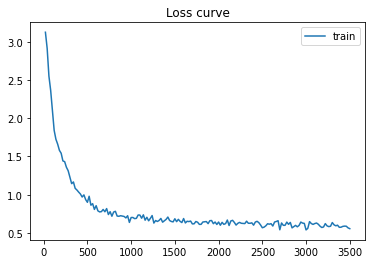

In [20]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()
#train/box_loss
#val/box_loss
#train/cls_loss
#val/cls_loss
#metric/p(B)
#metric/map50(B)
#metric/recall(B)
#metric/map50-95(B)

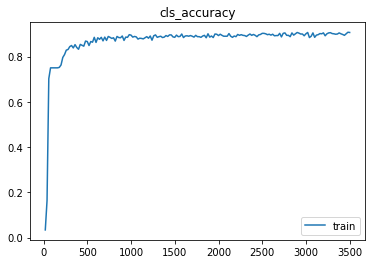

<Figure size 432x288 with 0 Axes>

In [21]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("cls_accuracy")
plt.show()
plt.savefig('ds_acc_small.png')


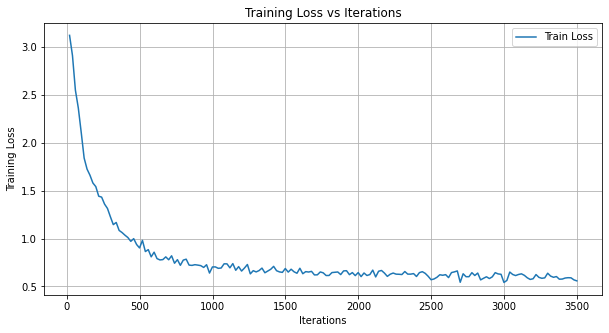

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt

# Extracting data from metrics_df
iterations = mdf["iteration"]
train_loss = mdf["total_loss"]

# Plotting the metrics
plt.figure(figsize=(10, 5))

# Training Loss vs Iterations
plt.plot(iterations, train_loss, label="Train Loss")
plt.xlabel("Iterations")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Iterations")
plt.legend()

plt.grid(True)
plt.show()
plt.savefig('training_loss_big.png')


# predictor

In [23]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/kaggle/working/output/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold for this model
cfg.DATASETS.TEST = ("test", )
predictor = DefaultPredictor(cfg)

In [24]:
# Register test dataset
DatasetCatalog.register("test", lambda: test_list)
MetadataCatalog.get("test").set(thing_classes=['Platelets', 'RBC', 'WBC'])

# Get test metadata
test_metadata = MetadataCatalog.get("test")
test_dataset = DatasetCatalog.get("test")


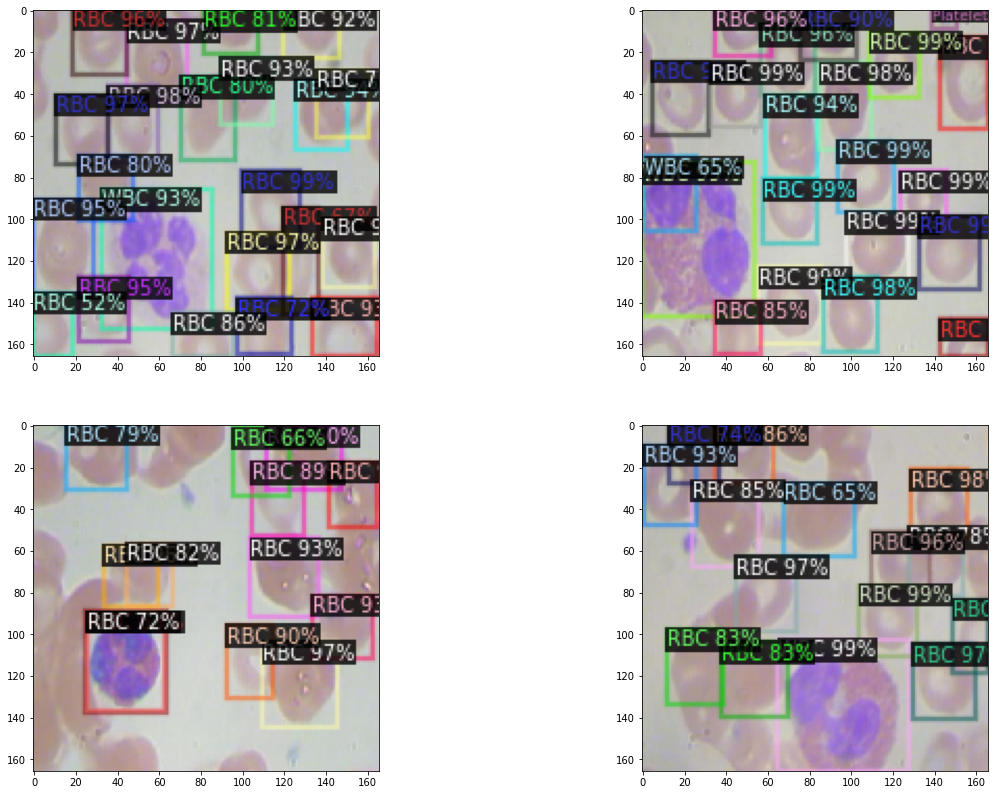

In [25]:
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer, ColorMode
import random

fig, ax = plt.subplots(2, 2, figsize=(20, 14))
indices = [ax[0][0], ax[1][0], ax[0][1], ax[1][1]]

i = -1
for d in random.sample(test_dataset, 4):
    i += 1    
    im = plt.imread(d["file_name"])  # Use matplotlib to read the image
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.4, 
                   instance_mode=ColorMode.IMAGE_BW)   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])

# Save the plot as an image file
plt.savefig('output_plot.png')

# Display the plot
plt.show()
